In [148]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import kurtosis, zscore

# Read, Convert

In [149]:
src_folder_path = "./data"
df = pd.concat([
    pd.read_csv(src_folder_path + "/20220421-a5ad2ede1017aadb3dd3df128cd0b0b5.csv", sep=";"),
    pd.read_csv(src_folder_path + "/20220425-a5ad2ede1017aadb3dd3df128cd0b0b5.csv", sep=";"),
    pd.read_csv(src_folder_path + "/20220522-a5ad2ede1017aadb3dd3df128cd0b0b5.csv", sep=";"),
    pd.read_csv(src_folder_path + "/20220528-a5ad2ede1017aadb3dd3df128cd0b0b5.csv", sep=";"),
    pd.read_csv(src_folder_path + "/20220605-8a170dfb7bc4f64e5e1596c216f18f74.csv", sep=";")
], ignore_index=True)

In [150]:
arrayFeatures = [
    "acc-x-m/s^2",
    "acc-y-m/s^2",
    "acc-z-m/s^2",
    "gyr-x-rad/s",
    "gyr-y-rad/s",
    "gyr-z-rad/s",
    "ori-angle-x-rad",
    "ori-angle-y-rad",
    "ori-angle-z-rad"
];

def array_from_string(x):
    if isinstance(x, str):
        x = x[1:] # remove first char "["
        x = x[:-1] # remove last char "]"
        return np.fromstring(x, sep=",")
    else:
        return x

# convert arrays
for curFeature in arrayFeatures:
    df[curFeature] = df[curFeature].apply(array_from_string)

In [151]:
STAYING = 10
JUMP_LEFT = 11
JUMP_RIGHT = 12
OTHER = 20
FAKE_JUMP_LEFT = 30
FAKE_JUMP_RIGHT = 31

SRC_LABEL_COL = 'activity'
LABEL_COL = 'activity-code'

def encode_label(value):
    if value == 'staying': return STAYING
    if value == 'jump_left': return JUMP_LEFT
    if value == 'jump_right': return JUMP_RIGHT
    if value == 'other': return OTHER
    if value == 'fake_jump_left': return FAKE_JUMP_LEFT
    if value == 'fake_jump_right': return FAKE_JUMP_RIGHT

# convert label
df[LABEL_COL] = df[SRC_LABEL_COL].apply(encode_label)

In [152]:
OUT_LABEL_COL = 'activity-class'

def get_activity_class(activityCode):
    #if activityCode == JUMP_LEFT or activityCode == JUMP_RIGHT:
    #    return 'lateral-move'
    if activityCode == JUMP_LEFT:
        return 'jump_left'
    if activityCode == JUMP_RIGHT:
        return 'jump_right'
    if activityCode == FAKE_JUMP_LEFT or activityCode== FAKE_JUMP_RIGHT:
        return 'fake-move'
    else:
        return 'staying'
    
# convert label
df[OUT_LABEL_COL] = df[LABEL_COL].apply(get_activity_class)

# Explore

In [153]:
df.columns

Index(['startDate', 'endDate', 'acc-accuracy', 'acc-x-m/s^2', 'acc-y-m/s^2',
       'acc-z-m/s^2', 'acc-x-min', 'acc-x-mean', 'acc-x-max', 'acc-x-var',
       'acc-x-std', 'acc-y-min', 'acc-y-mean', 'acc-y-max', 'acc-y-var',
       'acc-y-std', 'acc-z-min', 'acc-z-mean', 'acc-z-max', 'acc-z-var',
       'acc-z-std', 'gyr-accuracy', 'gyr-x-rad/s', 'gyr-y-rad/s',
       'gyr-z-rad/s', 'gyr-x-min', 'gyr-x-mean', 'gyr-x-max', 'gyr-x-var',
       'gyr-x-std', 'gyr-y-min', 'gyr-y-mean', 'gyr-y-max', 'gyr-y-var',
       'gyr-y-std', 'gyr-z-min', 'gyr-z-mean', 'gyr-z-max', 'gyr-z-var',
       'gyr-z-std', 'mag-accuracy', 'ori-angle-x-rad', 'ori-angle-y-rad',
       'ori-angle-z-rad', 'ori-angle-x-min', 'ori-angle-x-mean',
       'ori-angle-x-max', 'ori-angle-x-var', 'ori-angle-x-std',
       'ori-angle-y-min', 'ori-angle-y-mean', 'ori-angle-y-max',
       'ori-angle-y-var', 'ori-angle-y-std', 'ori-angle-z-min',
       'ori-angle-z-mean', 'ori-angle-z-max', 'ori-angle-z-var',
       'ori-angle-

In [154]:
df.head(3)

,startDate,endDate,acc-accuracy,acc-x-m/s^2,acc-y-m/s^2,acc-z-m/s^2,acc-x-min,acc-x-mean,acc-x-max,acc-x-var,...,ori-angle-y-std,ori-angle-z-min,ori-angle-z-mean,ori-angle-z-max,ori-angle-z-var,ori-angle-z-std,activity,device-id,activity-code,activity-class
0,2022-04-20T23:30:22.835Z,2022-04-20T23:30:24.111Z,2,"[0.04962164, 0.04962164, 0.04962164, 0.0496216...","[0.2781539, -0.2528081, -0.2528081, -0.2528081...","[-0.35332966, -0.9656162, -0.9656162, -0.96561...",-3.097097,0.051071,2.626643,1.009453,...,0.100828,0.092167,0.267150,0.538387,0.014938,0.122220,jump_left,a5ad2ede1017aadb3dd3df128cd0b0b5,11,jump_left
1,2022-04-20T23:30:29.997Z,2022-04-20T23:30:31.271Z,2,"[-0.08512929, -0.08512929, -0.08512929, -0.085...","[0.17111015, 0.17111015, 0.17111015, 0.1711101...","[-0.31947136, -0.31947136, -0.31947136, -0.319...",-3.812625,-0.221583,2.575436,1.578221,...,0.122976,0.007846,0.263486,0.916610,0.062400,0.249799,jump_right,a5ad2ede1017aadb3dd3df128cd0b0b5,12,jump_right
2,2022-04-20T23:30:39.887Z,2022-04-20T23:30:40.513Z,2,"[-0.67601275, -1.9999166, -1.4998112, 0.876384...","[-2.5262933, -1.9065523, -1.9065523, -1.406114...","[-3.6014862, -2.072174, -2.5946655, -4.345276,...",-3.812625,-0.189698,2.575436,1.432908,...,0.140555,0.054403,0.261767,0.916610,0.059338,0.243594,staying,a5ad2ede1017aadb3dd3df128cd0b0b5,10,staying


In [155]:
arraySizes = df['acc-x-m/s^2'].apply(lambda array: len(array))
arraySizes = list(set(arraySizes))
print("Raw array sizes: " + str(arraySizes))

Raw array sizes: [64]


In [156]:
def plot_data(dataArray, title):
    pltIndex = 131
    plt.figure(figsize=(14, 2))

    for curPlt in dataArray:
        plt.subplot(pltIndex)
        plt.plot(curPlt['data'])
        plt.ylabel(curPlt['name'])
        plt.grid(True)
        
        pltIndex += 1;

    plt.subplots_adjust(hspace=0.25, wspace=0.35)

    plt.suptitle(title)
    plt.show()

def plot_data_from_row(dataFrame, rowIndex, colNames, colLabel):
    pltData = []
    pltLabel = dataFrame.at[rowIndex, colLabel];
    
    for colName in colNames:
        pltData.append({ 'data': dataFrame.at[rowIndex, colName], 'name': colName })

    plot_data(pltData, pltLabel)

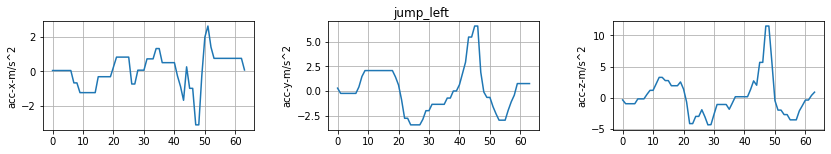

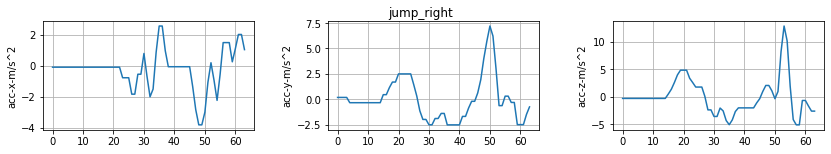

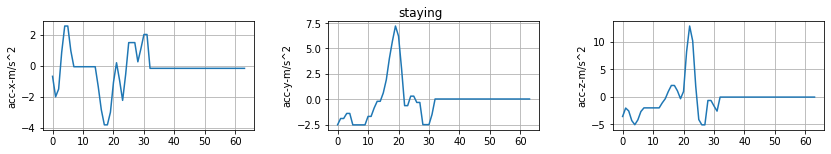

In [157]:
plot_data_from_row(df, 0, ['acc-x-m/s^2', 'acc-y-m/s^2', 'acc-z-m/s^2'], SRC_LABEL_COL)
plot_data_from_row(df, 1, ['acc-x-m/s^2', 'acc-y-m/s^2', 'acc-z-m/s^2'], SRC_LABEL_COL)
plot_data_from_row(df, 2, ['acc-x-m/s^2', 'acc-y-m/s^2', 'acc-z-m/s^2'], SRC_LABEL_COL)

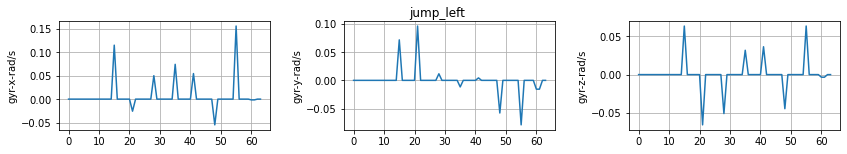

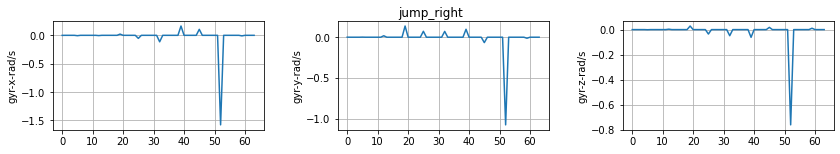

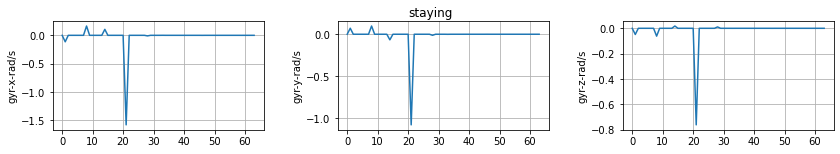

In [158]:
plot_data_from_row(df, 0, ['gyr-x-rad/s', 'gyr-y-rad/s', 'gyr-z-rad/s'], SRC_LABEL_COL)
plot_data_from_row(df, 1, ['gyr-x-rad/s', 'gyr-y-rad/s', 'gyr-z-rad/s'], SRC_LABEL_COL)
plot_data_from_row(df, 2, ['gyr-x-rad/s', 'gyr-y-rad/s', 'gyr-z-rad/s'], SRC_LABEL_COL)

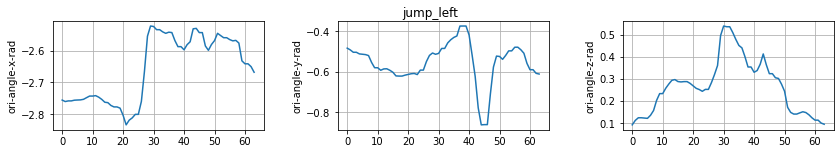

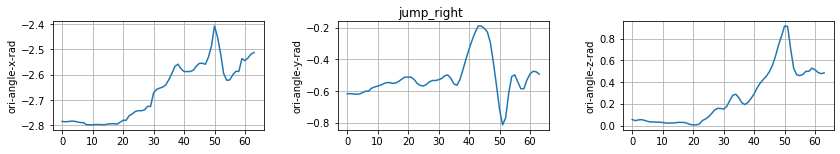

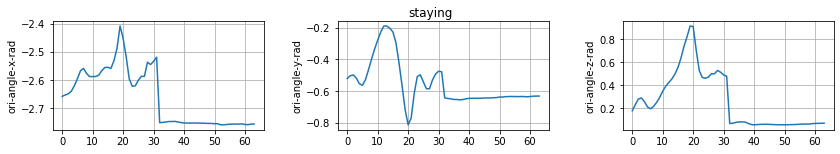

In [159]:
plot_data_from_row(df, 0, ['ori-angle-x-rad', 'ori-angle-y-rad', 'ori-angle-z-rad'], SRC_LABEL_COL)
plot_data_from_row(df, 1, ['ori-angle-x-rad', 'ori-angle-y-rad', 'ori-angle-z-rad'], SRC_LABEL_COL)
plot_data_from_row(df, 2, ['ori-angle-x-rad', 'ori-angle-y-rad', 'ori-angle-z-rad'], SRC_LABEL_COL)

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


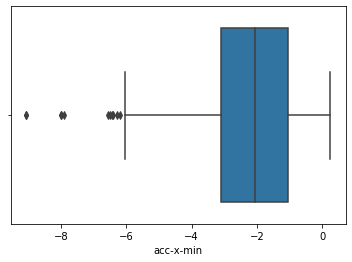

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


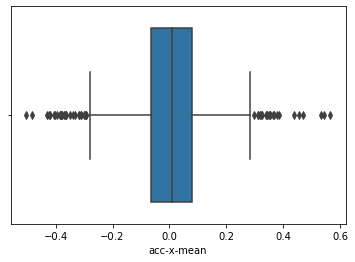

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


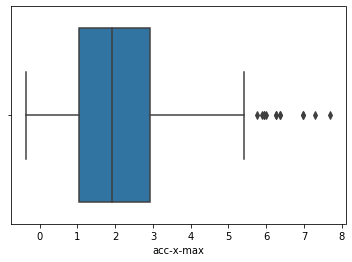

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


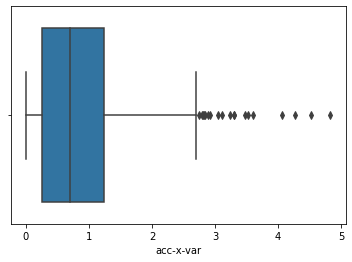

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


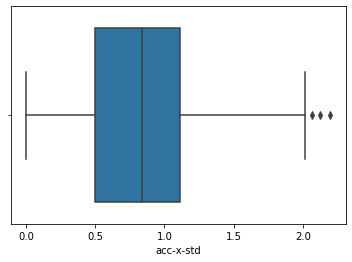

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


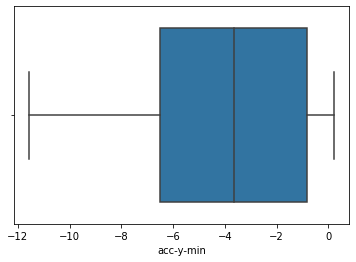

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


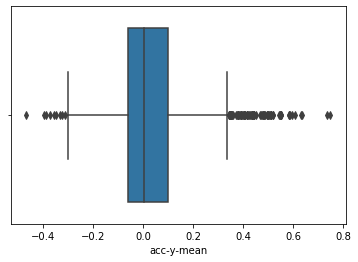

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


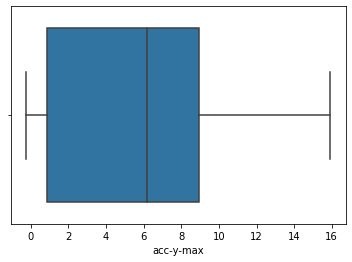

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


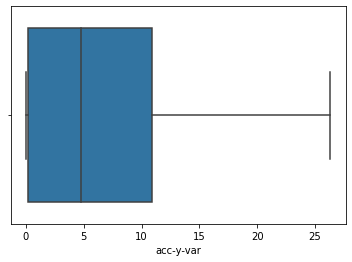

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


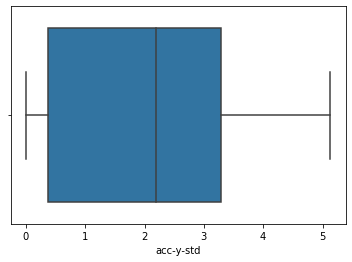

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


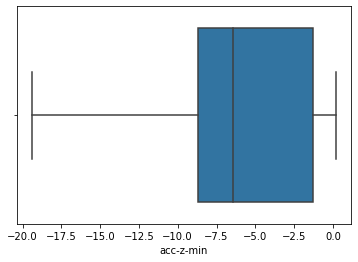

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


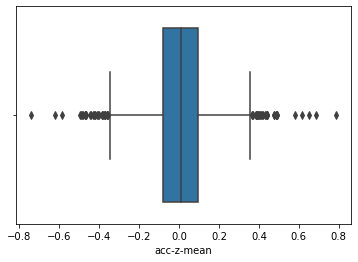

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


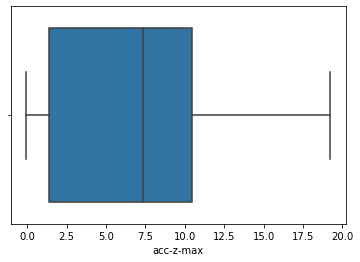

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


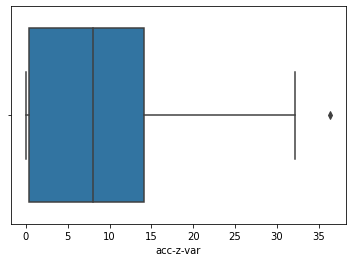

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


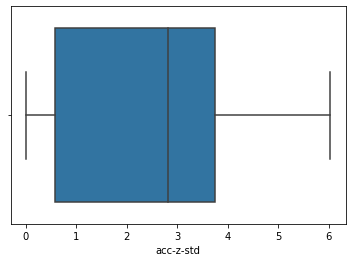

In [160]:
df_for_bp_acc = df[
    [
        'acc-x-min', 'acc-x-mean', 'acc-x-max', 'acc-x-var', 'acc-x-std',
        'acc-y-min', 'acc-y-mean', 'acc-y-max', 'acc-y-var', 'acc-y-std',
        'acc-z-min', 'acc-z-mean', 'acc-z-max', 'acc-z-var', 'acc-z-std',
    ]
].copy()

for column in df_for_bp_acc.columns:
    sn.boxplot(df_for_bp_acc[column])
    plt.show()

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


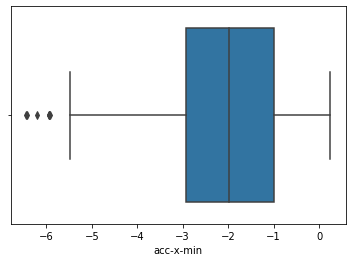

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


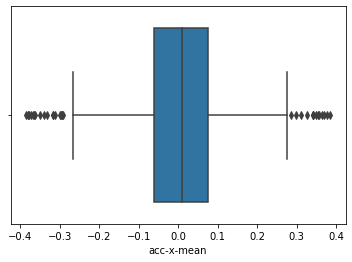

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


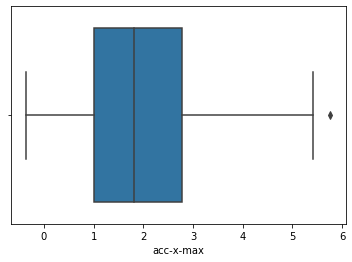

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


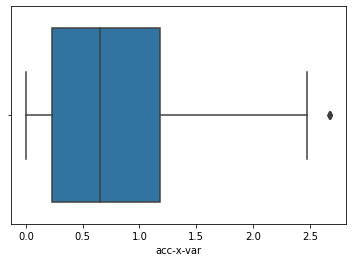

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


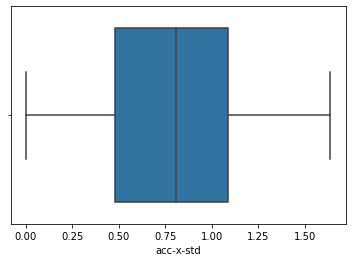

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


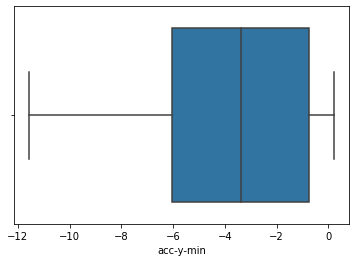

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


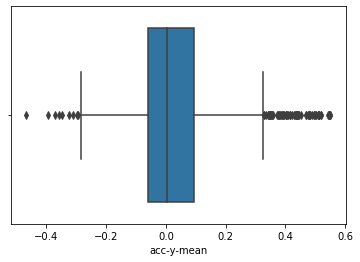

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


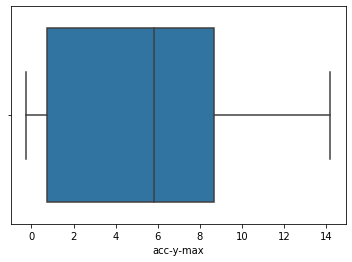

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


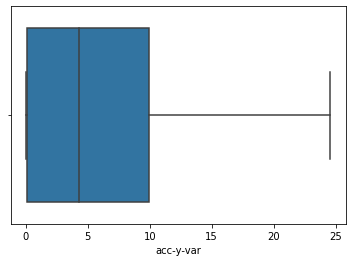

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


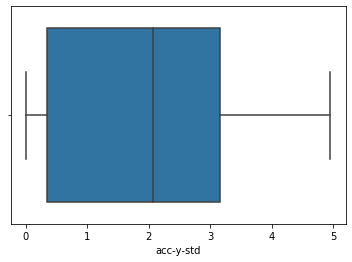

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


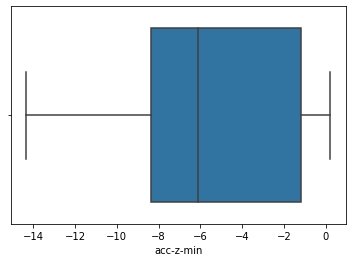

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


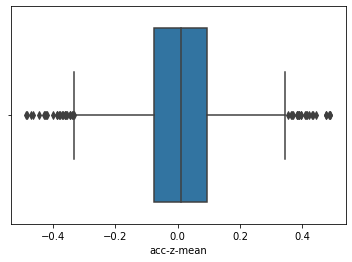

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


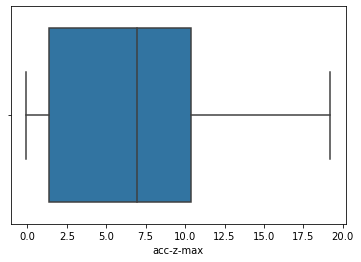

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


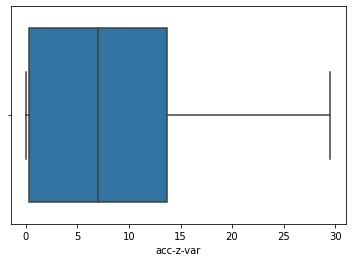

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


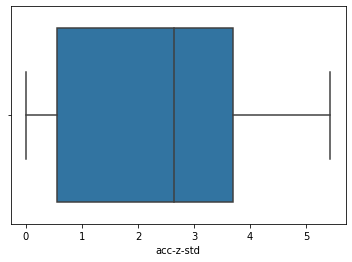

In [161]:
#remove outliers
# An outlier of a dataset is defined as a value that is more than 3 standard deviations from the mean
df_remove_outliers = df.copy()
df_remove_outliers = df_remove_outliers[np.abs(zscore(df_remove_outliers['acc-x-min'])) < 3]
df_remove_outliers = df_remove_outliers[np.abs(zscore(df_remove_outliers['acc-y-min'])) < 3]
df_remove_outliers = df_remove_outliers[np.abs(zscore(df_remove_outliers['acc-z-min'])) < 3]

df_remove_outliers = df_remove_outliers[np.abs(zscore(df_remove_outliers['acc-x-mean'])) < 3]
df_remove_outliers = df_remove_outliers[np.abs(zscore(df_remove_outliers['acc-y-mean'])) < 3]
df_remove_outliers = df_remove_outliers[np.abs(zscore(df_remove_outliers['acc-z-mean'])) < 3]

df_remove_outliers = df_remove_outliers[np.abs(zscore(df_remove_outliers['acc-x-max'])) < 3]
df_remove_outliers = df_remove_outliers[np.abs(zscore(df_remove_outliers['acc-y-max'])) < 3]
df_remove_outliers = df_remove_outliers[np.abs(zscore(df_remove_outliers['acc-z-max'])) < 3]

df_remove_outliers = df_remove_outliers[np.abs(zscore(df_remove_outliers['acc-x-var'])) < 3]
df_remove_outliers = df_remove_outliers[np.abs(zscore(df_remove_outliers['acc-y-var'])) < 3]
df_remove_outliers = df_remove_outliers[np.abs(zscore(df_remove_outliers['acc-z-var'])) < 3]

df_remove_outliers = df_remove_outliers[np.abs(zscore(df_remove_outliers['acc-x-std'])) < 3]
df_remove_outliers = df_remove_outliers[np.abs(zscore(df_remove_outliers['acc-y-std'])) < 3]
df_remove_outliers = df_remove_outliers[np.abs(zscore(df_remove_outliers['acc-z-std'])) < 3]

df_for_bp_acc = df_remove_outliers[
    [
        'acc-x-min', 'acc-x-mean', 'acc-x-max', 'acc-x-var', 'acc-x-std',
        'acc-y-min', 'acc-y-mean', 'acc-y-max', 'acc-y-var', 'acc-y-std',
        'acc-z-min', 'acc-z-mean', 'acc-z-max', 'acc-z-var', 'acc-z-std',
    ]
].copy()

for column in df_for_bp_acc.columns:
    sn.boxplot(df_for_bp_acc[column])
    plt.show()

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


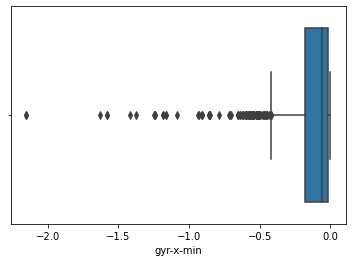

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


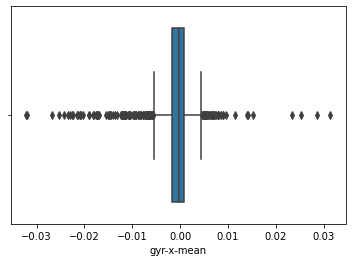

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


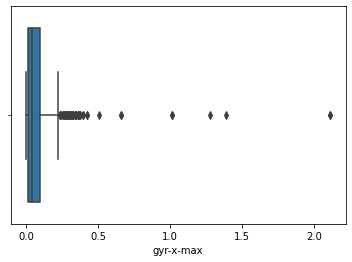

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


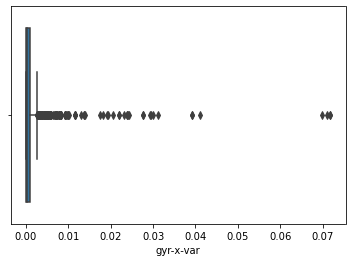

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


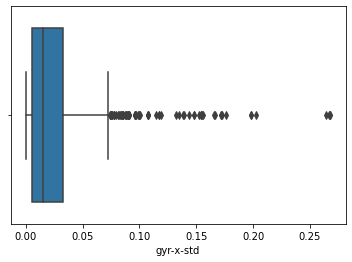

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


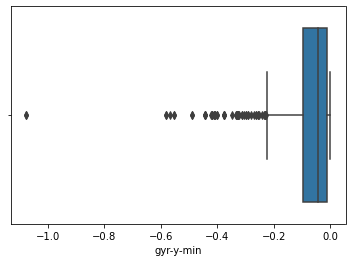

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


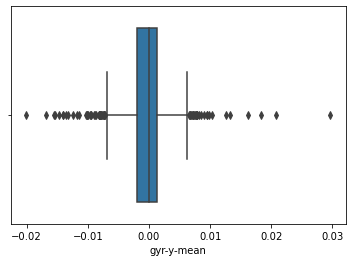

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


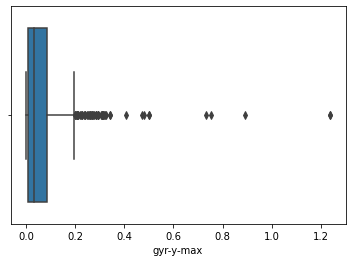

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


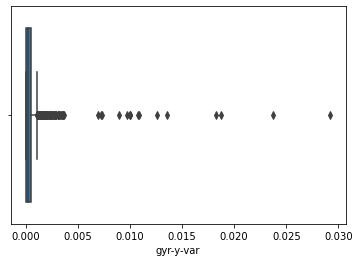

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


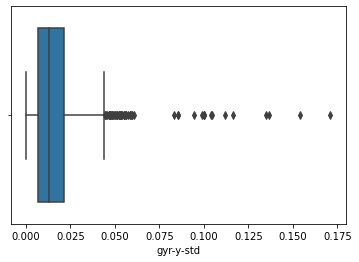

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


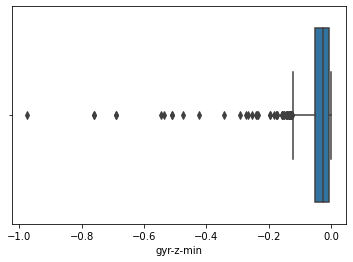

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


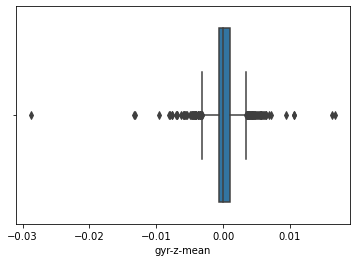

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


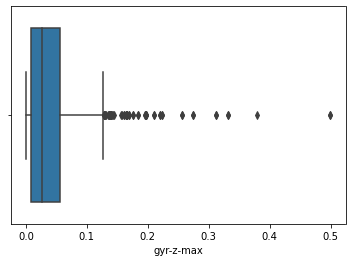

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


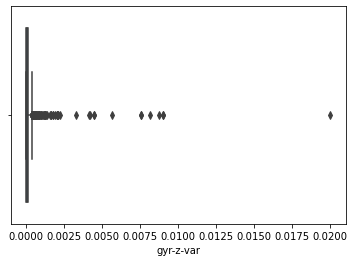

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


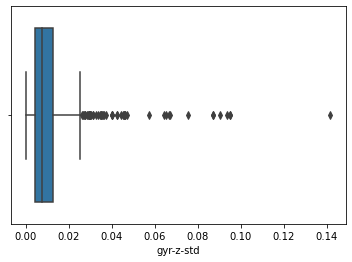

In [162]:
df_for_bp_gyr = df[
    [
        'gyr-x-min', 'gyr-x-mean', 'gyr-x-max', 'gyr-x-var', 'gyr-x-std',
        'gyr-y-min', 'gyr-y-mean', 'gyr-y-max', 'gyr-y-var', 'gyr-y-std',
        'gyr-z-min', 'gyr-z-mean', 'gyr-z-max', 'gyr-z-var', 'gyr-z-std',
    ]
].copy()

for column in df_for_bp_gyr.columns:
    sn.boxplot(df_for_bp_gyr[column])
    plt.show()

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


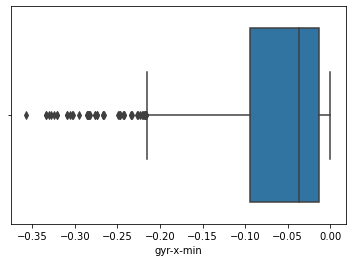

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


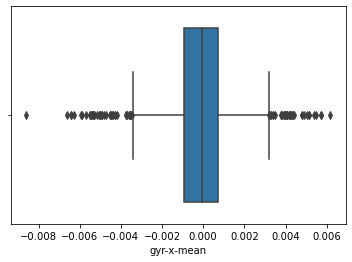

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


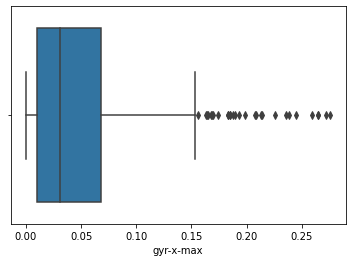

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


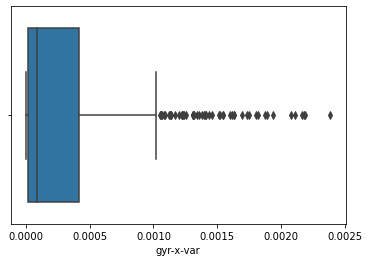

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


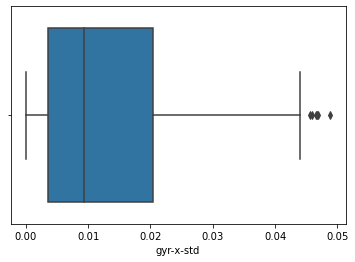

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


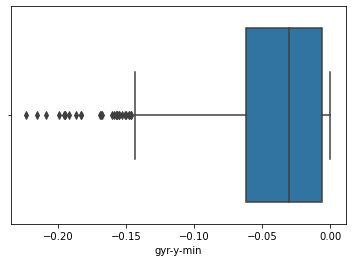

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


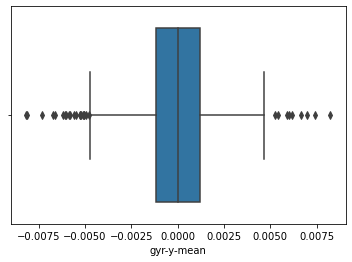

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


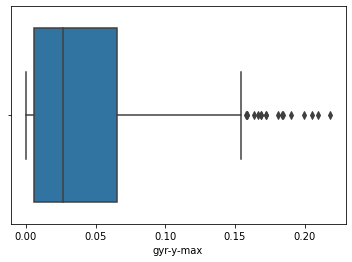

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


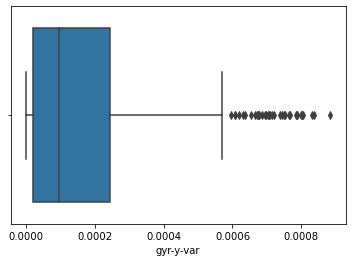

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


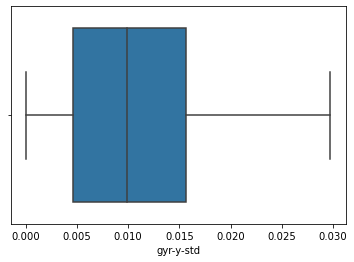

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


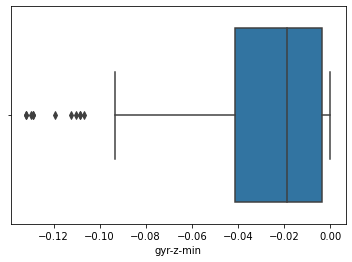

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


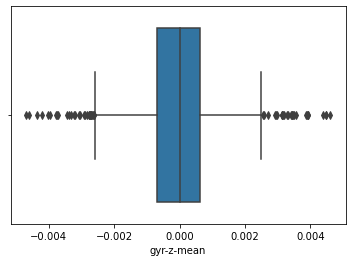

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


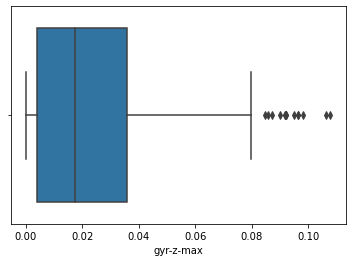

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


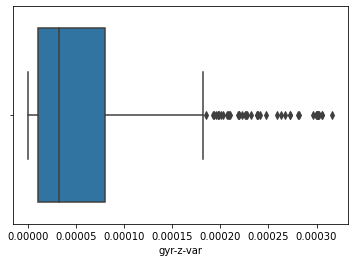

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


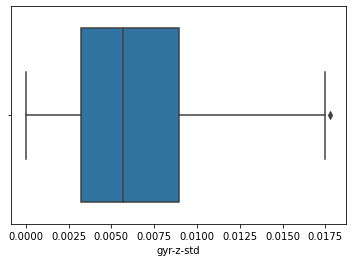

In [163]:
df_remove_outliers = df_remove_outliers[np.abs(zscore(df_remove_outliers['gyr-x-min'])) < 3]
df_remove_outliers = df_remove_outliers[np.abs(zscore(df_remove_outliers['gyr-y-min'])) < 3]
df_remove_outliers = df_remove_outliers[np.abs(zscore(df_remove_outliers['gyr-z-min'])) < 3]

df_remove_outliers = df_remove_outliers[np.abs(zscore(df_remove_outliers['gyr-x-mean'])) < 3]
df_remove_outliers = df_remove_outliers[np.abs(zscore(df_remove_outliers['gyr-y-mean'])) < 3]
df_remove_outliers = df_remove_outliers[np.abs(zscore(df_remove_outliers['gyr-z-mean'])) < 3]

df_remove_outliers = df_remove_outliers[np.abs(zscore(df_remove_outliers['gyr-x-max'])) < 3]
df_remove_outliers = df_remove_outliers[np.abs(zscore(df_remove_outliers['gyr-y-max'])) < 3]
df_remove_outliers = df_remove_outliers[np.abs(zscore(df_remove_outliers['gyr-z-max'])) < 3]

df_remove_outliers = df_remove_outliers[np.abs(zscore(df_remove_outliers['gyr-x-var'])) < 3]
df_remove_outliers = df_remove_outliers[np.abs(zscore(df_remove_outliers['gyr-y-var'])) < 3]
df_remove_outliers = df_remove_outliers[np.abs(zscore(df_remove_outliers['gyr-z-var'])) < 3]

df_remove_outliers = df_remove_outliers[np.abs(zscore(df_remove_outliers['gyr-x-std'])) < 3]
df_remove_outliers = df_remove_outliers[np.abs(zscore(df_remove_outliers['gyr-y-std'])) < 3]
df_remove_outliers = df_remove_outliers[np.abs(zscore(df_remove_outliers['gyr-z-std'])) < 3]

df_for_bp_gyr = df_remove_outliers[
    [
        'gyr-x-min', 'gyr-x-mean', 'gyr-x-max', 'gyr-x-var', 'gyr-x-std',
        'gyr-y-min', 'gyr-y-mean', 'gyr-y-max', 'gyr-y-var', 'gyr-y-std',
        'gyr-z-min', 'gyr-z-mean', 'gyr-z-max', 'gyr-z-var', 'gyr-z-std',
    ]
].copy()

for column in df_for_bp_gyr.columns:
    sn.boxplot(df_for_bp_gyr[column])
    plt.show()

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


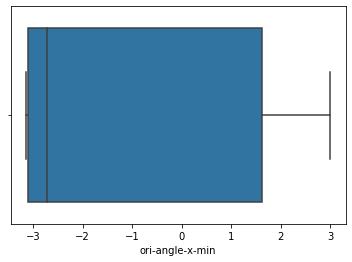

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


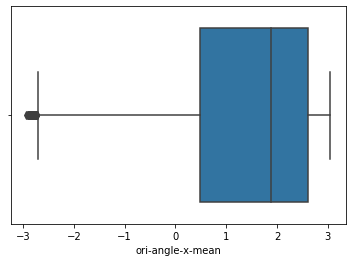

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


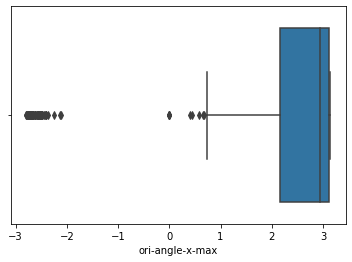

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


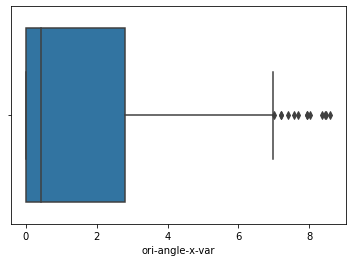

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


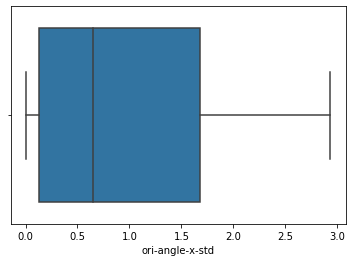

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


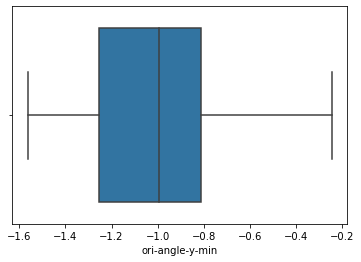

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


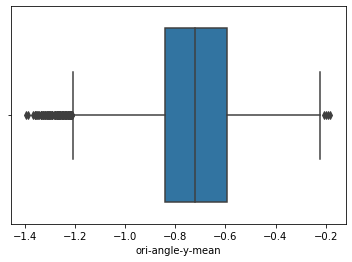

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


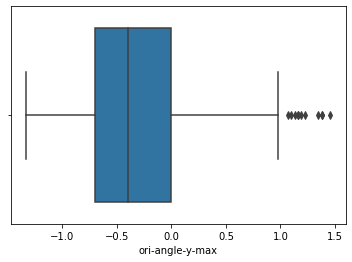

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


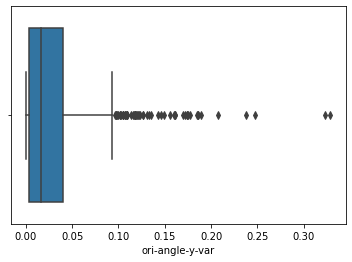

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


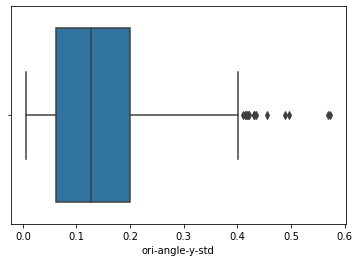

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


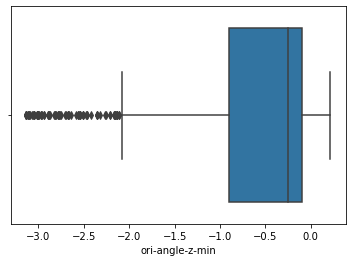

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


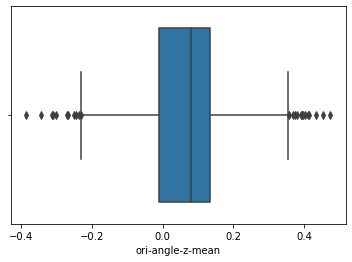

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


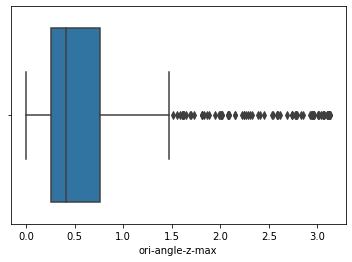

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


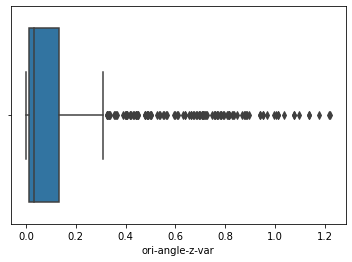

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


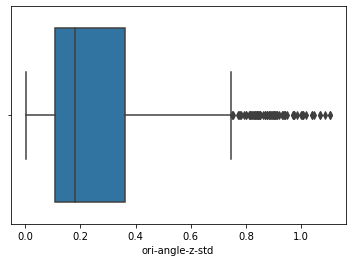

In [164]:
df_for_bp_ori_angle = df[
    [
        'ori-angle-x-min', 'ori-angle-x-mean', 'ori-angle-x-max', 'ori-angle-x-var', 'ori-angle-x-std',
        'ori-angle-y-min', 'ori-angle-y-mean', 'ori-angle-y-max', 'ori-angle-y-var', 'ori-angle-y-std',
        'ori-angle-z-min', 'ori-angle-z-mean', 'ori-angle-z-max', 'ori-angle-z-var', 'ori-angle-z-std',
    ]
].copy()

for column in df_for_bp_ori_angle.columns:
    sn.boxplot(df_for_bp_ori_angle[column])
    plt.show()

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


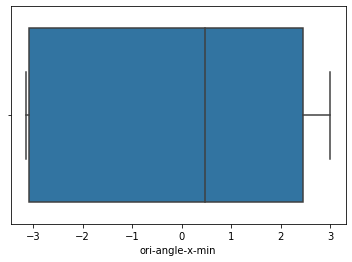

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


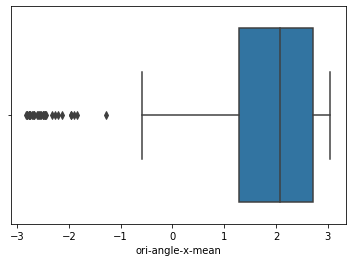

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


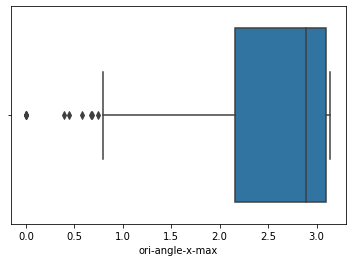

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


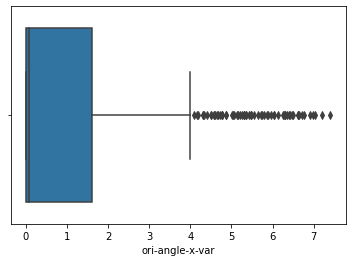

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


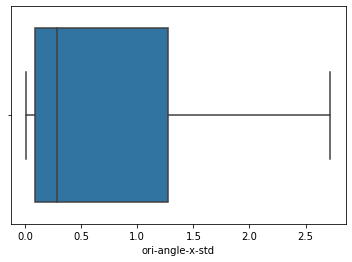

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


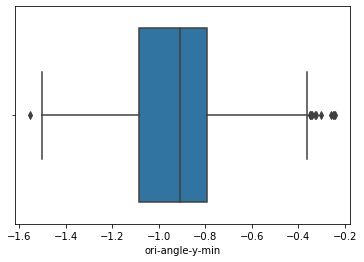

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


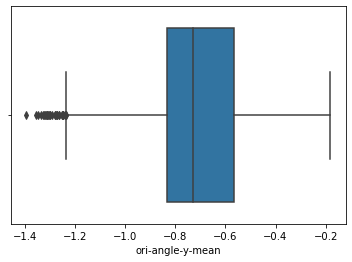

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


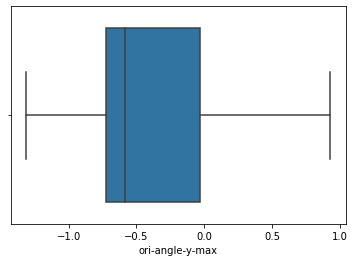

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


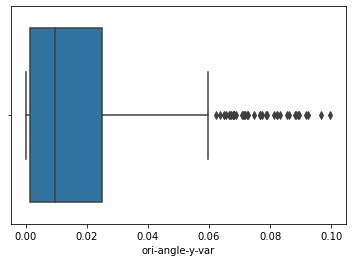

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


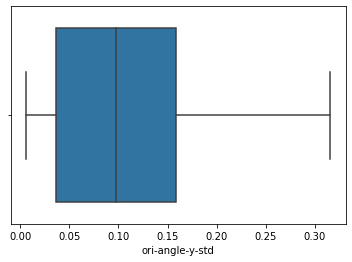

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


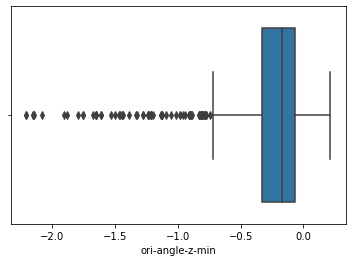

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


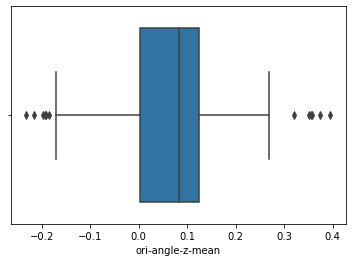

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


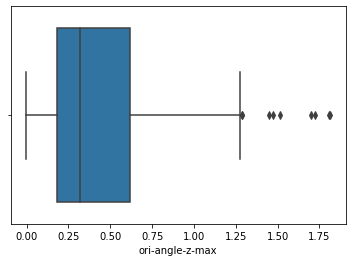

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


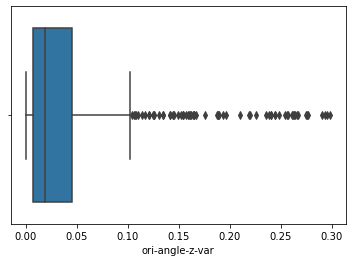

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


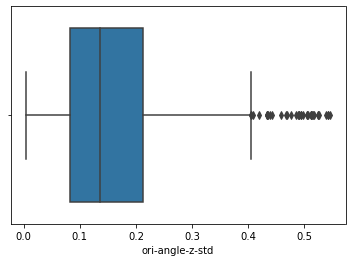

In [165]:
df_remove_outliers = df_remove_outliers[np.abs(zscore(df_remove_outliers['ori-angle-x-min'])) < 3]
df_remove_outliers = df_remove_outliers[np.abs(zscore(df_remove_outliers['ori-angle-y-min'])) < 3]
df_remove_outliers = df_remove_outliers[np.abs(zscore(df_remove_outliers['ori-angle-z-min'])) < 3]

df_remove_outliers = df_remove_outliers[np.abs(zscore(df_remove_outliers['ori-angle-x-mean'])) < 3]
df_remove_outliers = df_remove_outliers[np.abs(zscore(df_remove_outliers['ori-angle-y-mean'])) < 3]
df_remove_outliers = df_remove_outliers[np.abs(zscore(df_remove_outliers['ori-angle-z-mean'])) < 3]

df_remove_outliers = df_remove_outliers[np.abs(zscore(df_remove_outliers['ori-angle-x-max'])) < 3]
df_remove_outliers = df_remove_outliers[np.abs(zscore(df_remove_outliers['ori-angle-y-max'])) < 3]
df_remove_outliers = df_remove_outliers[np.abs(zscore(df_remove_outliers['ori-angle-z-max'])) < 3]

df_remove_outliers = df_remove_outliers[np.abs(zscore(df_remove_outliers['ori-angle-x-var'])) < 3]
df_remove_outliers = df_remove_outliers[np.abs(zscore(df_remove_outliers['ori-angle-y-var'])) < 3]
df_remove_outliers = df_remove_outliers[np.abs(zscore(df_remove_outliers['ori-angle-z-var'])) < 3]

df_remove_outliers = df_remove_outliers[np.abs(zscore(df_remove_outliers['ori-angle-x-std'])) < 3]
df_remove_outliers = df_remove_outliers[np.abs(zscore(df_remove_outliers['ori-angle-y-std'])) < 3]
df_remove_outliers = df_remove_outliers[np.abs(zscore(df_remove_outliers['ori-angle-z-std'])) < 3]

df_for_bp_ori_angle = df_remove_outliers[
    [
        'ori-angle-x-min', 'ori-angle-x-mean', 'ori-angle-x-max', 'ori-angle-x-var', 'ori-angle-x-std',
        'ori-angle-y-min', 'ori-angle-y-mean', 'ori-angle-y-max', 'ori-angle-y-var', 'ori-angle-y-std',
        'ori-angle-z-min', 'ori-angle-z-mean', 'ori-angle-z-max', 'ori-angle-z-var', 'ori-angle-z-std',
    ]
].copy()

for column in df_for_bp_ori_angle.columns:
    sn.boxplot(df_for_bp_ori_angle[column])
    plt.show()

In [166]:
# reindex
df_remove_outliers = df_remove_outliers.reset_index(drop=True)

#apply outliers
df = df_remove_outliers

# Clean

In [167]:
# remove date cols
df.drop('startDate', inplace=True, axis=1)
df.drop('endDate', inplace=True, axis=1)

# remove sensor accuracy cols
df.drop('acc-accuracy', inplace=True, axis=1)
df.drop('gyr-accuracy', inplace=True, axis=1)
df.drop('mag-accuracy', inplace=True, axis=1)

# remove device-id col
df.drop('device-id', inplace=True, axis=1)

# Enrichment

In [168]:
# signal vector magnitude = sqrt(x^2 + y^2 + z^2)
def svmag(xArray, yArray, zArray):
    svmag_array = np.square([xArray, yArray, zArray])
    svmag_array = np.sum(svmag_array, axis=0)
    svmag_array = np.sqrt(svmag_array)
    return svmag_array

# signal magnitude area = sum(abs(x) + abs(y) + abs(z)) / arraySize
def sma(xArray, yArray, zArray):
    arraySize = len(xArray)
    result = np.abs([xArray, yArray, zArray])
    result = np.sum(result)
    return result / arraySize

# pearson correlation coefficient = cov(A, B) / (std(A) * std(B))
def pcorr(arrayA, arrayB):
    corr_matrix = np.corrcoef(arrayA, arrayB)
    corr = corr_matrix[0][1]
    
    if np.isnan(corr):
        return 0
    else:
        return corr
    
# difference between max and min positions
def min_max_diff(array):
    maxIndex = np.argmax(array, axis=0)
    minIndex = np.argmin(array, axis=0)
    return maxIndex - minIndex

# amplitude range = max - min
def amprange(array):
    return np.max(array) - np.min(array)

# average of array quarter
def mean_of_quarter(array, fromIndex, toIndex):
    array = array[fromIndex:toIndex]
    return np.mean(array)

# average peak-trough distance
def aptd(array):
    peakValue = array[0]
    troughValue = array[0]
    prevSlope = 0
    curSlope = 0
    sum = 0
    arraySize = len(array)
    evaluateSize = arraySize + 1
    
    for i in range(evaluateSize):
        if i == 0:
            curValue = array[i]
            continue
        
        prevValue = curValue
        prevSlope = curSlope
        
        if i < arraySize:
            curValue = array[i]
            curSlope = curValue - prevValue
        else:
            curSlope = prevSlope * -1
        
        # peak found
        if prevSlope > 0 and curSlope <= 0:
            peakValue = prevValue
            sum += peakValue - troughValue
            #print(f'=== peak found ({troughValue} to {peakValue})')
        # trough found
        elif prevSlope < 0 and curSlope >= 0:
            troughValue = prevValue
            sum += troughValue - peakValue
            #print(f'=== trough found ({peakValue} to {troughValue})')
            
    return sum / arraySize

def median_absolute_deviation(array):
    return np.median(np.absolute(array - np.median(array)))

def fft(array):
    #print(array)
    dft1 = np.fft.fft(array)

    dft1_real = np.real( dft1 )
    #print(dft1_real)
    dft1_imag = np.imag( dft1 )
    #print(dft1_imag)

    magFft = []

    for i in range(len(dft1_real)):
        magFft.append(np.sqrt(np.square(dft1_real[i]) + np.square(dft1_imag[i])))
    
    return magFft

def energy(magFftArray):
    energy = 0
    
    for i in range(len(magFftArray)):
        energy = energy + np.square(magFftArray[i])
    
    if len(magFftArray) > 0:
        energy = energy / len(magFftArray)
    
    return energy

def entropy(magFftArray):
    entropy = 0
    psd = []
    
    if len(magFftArray) > 0:
        for i in range(len(magFftArray)):
            psd.append(np.square(magFftArray[i]) / len(magFftArray))
    
        psdSum = np.sum(psd)
        
        if psdSum > 0:
            for i in range(len(magFftArray)):
                psd[i] = psd[i] / psdSum
                
            for i in range(len(magFftArray)):
                if psd[i] != 0:
                    entropy = entropy + (psd[i] * np.log(psd[i]))
    
            entropy = entropy * -1
    
    return entropy

def calc_kurtosis(array):
    return kurtosis(array, fisher=False)

def medfilt (array, k):
    """Apply a length-k median filter to a 1D array x.
    Boundaries are extended by repeating endpoints.
    """
    assert k % 2 == 1, "Median filter length must be odd."
    assert array.ndim == 1, "Input must be one-dimensional."
    k2 = (k - 1) // 2
    y = np.zeros ((len (array), k), dtype=array.dtype)
    y[:,k2] = array
    
    for i in range (k2):
        j = k2 - i
        y[j:,i] = array[:-j]
        y[:j,i] = array[0]
        y[:-j,-(i+1)] = array[j:]
        y[-j:,-(i+1)] = array[-1]
        
    return np.median (y, axis=1)

def meanfilt (array, k):
    """Apply a length-k mean filter to a 1D array x.
    Boundaries are extended by repeating endpoints.
    """

    assert k % 2 == 1, "Mean filter length must be odd."
    assert array.ndim == 1, "Input must be one-dimensional."
    
    k2 = (k - 1) // 2
    y = np.zeros ((len (array), k), dtype=array.dtype)
    y[:,k2] = array
    for i in range (k2):
        j = k2 - i
        y[j:,i] = array[:-j]
        y[:j,i] = array[0]
        y[:-j,-(i+1)] = array[j:]
        y[-j:,-(i+1)] = array[-1]
    return np.mean (y, axis=1)

[ 0.26908183 -2.8245993  -2.8245993  -1.4604974   0.23052788  1.2465317
  1.9658778   1.9658778   1.9658778   1.9658778   1.9658778   1.020895
  1.020895    0.18783319  0.18783319  0.18783319  0.18783319  0.18783319
  0.18783319  0.18783319  0.8683553  -0.6453147  -0.6453147  -0.6453147
 -0.6453147  -0.6453147  -0.6453147  -0.6453147  -0.6453147  -0.6453147
 -0.6453147  -0.6453147  -0.3641236  -0.3641236  -0.3641236  -0.3641236
 -0.3641236  -0.3641236  -0.3641236  -0.3641236  -0.3641236  -0.3641236
 -0.3641236  -0.3641236  -0.3641236  -0.3641236  -0.3641236  -0.3641236
 -0.3641236  -0.3641236  -0.3641236  -0.3641236  -0.3641236  -0.3641236
 -0.3641236  -0.3641236  -0.3641236  -0.3641236  -0.3641236  -0.3641236
 -0.3641236  -0.3641236  -0.3641236  -0.3641236 ]


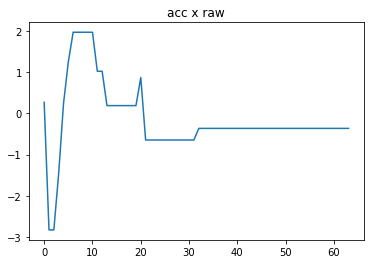

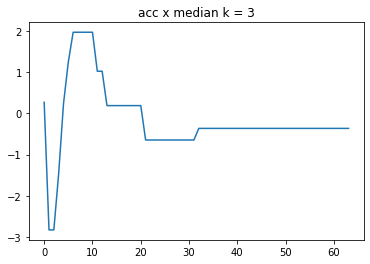

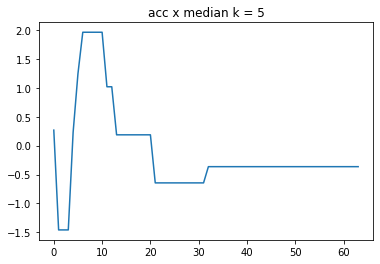

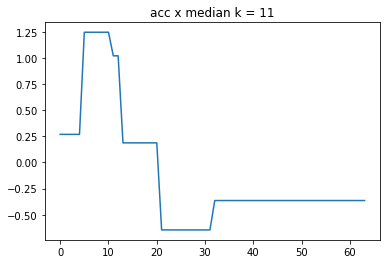

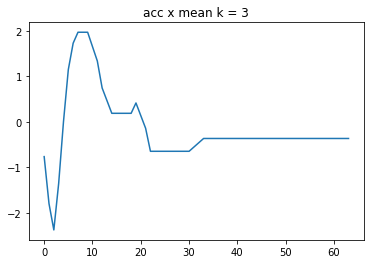

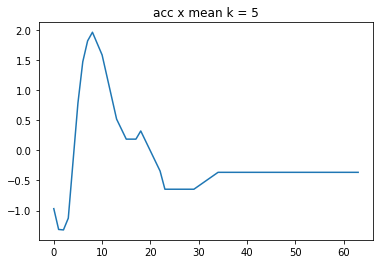

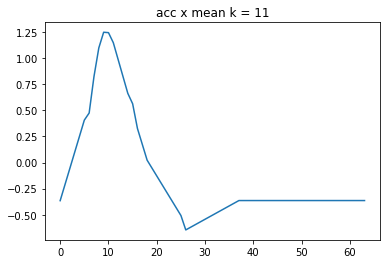

In [169]:
print(df.at[0, 'acc-x-m/s^2'])
#print(fft(df.at[0, 'acc-x-m/s^2']))
#print(energy(fft(df.at[0, 'acc-x-m/s^2'])))
#print(entropy(fft(df.at[0, 'acc-x-m/s^2'])))
#print(calc_kurtosis(df.at[0, 'acc-x-m/s^2']))
#print(medfilt(df.at[0, 'acc-x-m/s^2'], 3))
#print(medfilt(df.at[0, 'acc-x-m/s^2'], 5))

plt.plot(df.at[0, 'acc-x-m/s^2'])
plt.title('acc x raw')
plt.show()

plt.plot(medfilt(df.at[0, 'acc-x-m/s^2'], 3))
plt.title('acc x median k = 3')
plt.show()
plt.plot(medfilt(df.at[0, 'acc-x-m/s^2'], 5))
plt.title('acc x median k = 5')
plt.show()
plt.plot(medfilt(df.at[0, 'acc-x-m/s^2'], 11))
plt.title('acc x median k = 11')
plt.show()

plt.plot(meanfilt(df.at[0, 'acc-x-m/s^2'], 3))
plt.title('acc x mean k = 3')
plt.show()
plt.plot(meanfilt(df.at[0, 'acc-x-m/s^2'], 5))
plt.title('acc x mean k = 5')
plt.show()
plt.plot(meanfilt(df.at[0, 'acc-x-m/s^2'], 11))
plt.title('acc x mean k = 11')
plt.show()

In [170]:
#apply filter
df_filter = df.copy()

filter_type = 'median'
#filter_type = 'mean'

if filter_type == 'median':
    k = 3 # try with 5 and 11
    for index, row in df_filter.iterrows():
        #maybe comment acc, because there is already a filter in java code, try with and without
        #df_filter.at[index, 'acc-x-m/s^2'] = medfilt(df_filter.at[index, 'acc-x-m/s^2'], k)
        #df_filter.at[index, 'acc-y-m/s^2'] = medfilt(df_filter.at[index, 'acc-y-m/s^2'], k)
        #df_filter.at[index, 'acc-z-m/s^2'] = medfilt(df_filter.at[index, 'acc-z-m/s^2'], k)

        df_filter.at[index, 'gyr-x-rad/s'] = medfilt(df_filter.at[index, 'gyr-x-rad/s'], k)
        df_filter.at[index, 'gyr-y-rad/s'] = medfilt(df_filter.at[index, 'gyr-y-rad/s'], k)
        df_filter.at[index, 'gyr-z-rad/s'] = medfilt(df_filter.at[index, 'gyr-z-rad/s'], k)

        df_filter.at[index, 'ori-angle-x-rad'] = medfilt(df_filter.at[index, 'ori-angle-x-rad'], k)
        df_filter.at[index, 'ori-angle-y-rad'] = medfilt(df_filter.at[index, 'ori-angle-y-rad'], k)
        df_filter.at[index, 'ori-angle-z-rad'] = medfilt(df_filter.at[index, 'ori-angle-z-rad'], k)

elif filter_type == 'mean':
    k = 3 # try with 5 and 11
    for index, row in df_filter.iterrows():
        #maybe comment acc, because there is already a filter in java code, try with and without
        #df_filter.at[index, 'acc-x-m/s^2'] = meanfilt(df_filter.at[index, 'acc-x-m/s^2'], k)
        #df_filter.at[index, 'acc-y-m/s^2'] = meanfilt(df_filter.at[index, 'acc-y-m/s^2'], k)
        #df_filter.at[index, 'acc-z-m/s^2'] = meanfilt(df_filter.at[index, 'acc-z-m/s^2'], k)

        df_filter.at[index, 'gyr-x-rad/s'] = meanfilt(df_filter.at[index, 'gyr-x-rad/s'], k)
        df_filter.at[index, 'gyr-y-rad/s'] = meanfilt(df_filter.at[index, 'gyr-y-rad/s'], k)
        df_filter.at[index, 'gyr-z-rad/s'] = meanfilt(df_filter.at[index, 'gyr-z-rad/s'], k)

        df_filter.at[index, 'ori-angle-x-rad'] = meanfilt(df_filter.at[index, 'ori-angle-x-rad'], k)
        df_filter.at[index, 'ori-angle-y-rad'] = meanfilt(df_filter.at[index, 'ori-angle-y-rad'], k)
        df_filter.at[index, 'ori-angle-z-rad'] = meanfilt(df_filter.at[index, 'ori-angle-z-rad'], k)

In [171]:
#apply filters
#df = df_filter

In [172]:
newFeatures = [
    # accelerometer
    {
        'name': 'acc-svmag', 'dtype': object,
        'func': (lambda row: svmag(row["acc-x-m/s^2"], row["acc-y-m/s^2"], row["acc-z-m/s^2"]))
    },
    { 
        'name': 'acc-sma', 'dtype': np.float64,
        'func': (lambda row: sma(row["acc-x-m/s^2"], row["acc-y-m/s^2"], row["acc-z-m/s^2"]))
    },
    { 
        'name': 'acc-pcorr-xy', 'dtype': np.float64,
        'func': (lambda row: pcorr(row["acc-x-m/s^2"], row["acc-y-m/s^2"]))
    },
    { 
        'name': 'acc-pcorr-xz', 'dtype': np.float64,
        'func': (lambda row: pcorr(row["acc-x-m/s^2"], row["acc-z-m/s^2"]))
    },
    { 
        'name': 'acc-pcorr-yz', 'dtype': np.float64,
        'func': (lambda row: pcorr(row["acc-y-m/s^2"], row["acc-z-m/s^2"]))
    },
    {
        'name': 'acc-x-min-max-diff', 'dtype': np.float64,
        'func': (lambda row: min_max_diff(row["acc-x-m/s^2"]))
    },
    {
        'name': 'acc-x-amprange', 'dtype': np.float64,
        'func': (lambda row: amprange(row["acc-x-m/s^2"]))
    },
    {
        'name': 'acc-x-mean-1quarter', 'dtype': np.float64,
        'func': (lambda row: mean_of_quarter(row["acc-x-m/s^2"], 0, 16))
    },
    {
        'name': 'acc-x-mean-2quarter', 'dtype': np.float64,
        'func': (lambda row: mean_of_quarter(row["acc-x-m/s^2"], 16, 32))
    },
    {
        'name': 'acc-x-mean-3quarter', 'dtype': np.float64,
        'func': (lambda row: mean_of_quarter(row["acc-x-m/s^2"], 32, 48))
    },
    {
        'name': 'acc-x-mean-4quarter', 'dtype': np.float64,
        'func': (lambda row: mean_of_quarter(row["acc-x-m/s^2"], 32, 64))
    },
    {
        'name': 'acc-x-aptd', 'dtype': np.float64,
        'func': (lambda row: aptd(row["acc-x-m/s^2"]))
    },
    {
        'name': 'acc-y-aptd', 'dtype': np.float64,
        'func': (lambda row: aptd(row["acc-y-m/s^2"]))
    },
    {
        'name': 'acc-z-aptd', 'dtype': np.float64,
        'func': (lambda row: aptd(row["acc-z-m/s^2"]))
    },
    {
        'name': 'acc-x-mad', 'dtype': np.float64,
        'func': (lambda row: median_absolute_deviation(row["acc-x-m/s^2"]))
    },
    {
        'name': 'acc-y-mad', 'dtype': np.float64,
        'func': (lambda row: median_absolute_deviation(row["acc-y-m/s^2"]))
    },
    {
        'name': 'acc-z-mad', 'dtype': np.float64,
        'func': (lambda row: median_absolute_deviation(row["acc-z-m/s^2"]))
    },
    {
        'name': 'acc-x-fft', 'dtype': object,
        'func': (lambda row: fft(row["acc-x-m/s^2"]))
    },
    {
        'name': 'acc-y-fft', 'dtype': object,
        'func': (lambda row: fft(row["acc-y-m/s^2"]))
    },
    {
        'name': 'acc-z-fft', 'dtype': object,
        'func': (lambda row: fft(row["acc-z-m/s^2"]))
    },
    {
        'name': 'acc-x-energy', 'dtype': np.float64,
        'func': (lambda row: energy(row["acc-x-fft"]))
    },
    {
        'name': 'acc-y-energy', 'dtype': np.float64,
        'func': (lambda row: energy(row["acc-y-fft"]))
    },
    {
        'name': 'acc-z-energy', 'dtype': np.float64,
        'func': (lambda row: energy(row["acc-z-fft"]))
    },
    {
        'name': 'acc-x-entropy', 'dtype': np.float64,
        'func': (lambda row: entropy(row["acc-x-fft"]))
    },
    {
        'name': 'acc-y-entropy', 'dtype': np.float64,
        'func': (lambda row: entropy(row["acc-y-fft"]))
    },
    {
        'name': 'acc-z-entropy', 'dtype': np.float64,
        'func': (lambda row: entropy(row["acc-z-fft"]))
    },
    {
        'name': 'acc-x-kurtosis', 'dtype': np.float64,
        'func': (lambda row: calc_kurtosis(row["acc-x-m/s^2"]))
    },
    {
        'name': 'acc-y-kurtosis', 'dtype': np.float64,
        'func': (lambda row: calc_kurtosis(row["acc-y-m/s^2"]))
    },
    {
        'name': 'acc-z-kurtosis', 'dtype': np.float64,
        'func': (lambda row: calc_kurtosis(row["acc-z-m/s^2"]))
    },
    # gyroscope
    {
        'name': 'gyr-svmag', 'dtype': object,
        'func': (lambda row: svmag(row["gyr-x-rad/s"], row["gyr-y-rad/s"], row["gyr-z-rad/s"]))
    },
    { 
        'name': 'gyr-sma', 'dtype': np.float64,
        'func': (lambda row: sma(row["gyr-x-rad/s"], row["gyr-y-rad/s"], row["gyr-z-rad/s"]))
    },
    { 
        'name': 'gyr-pcorr-xy', 'dtype': np.float64,
        'func': (lambda row: pcorr(row["gyr-x-rad/s"], row["gyr-y-rad/s"]))
    },
    { 
        'name': 'gyr-pcorr-xz', 'dtype': np.float64,
        'func': (lambda row: pcorr(row["gyr-x-rad/s"], row["gyr-z-rad/s"]))
    },
    { 
        'name': 'gyr-pcorr-yz', 'dtype': np.float64,
        'func': (lambda row: pcorr(row["gyr-y-rad/s"], row["gyr-z-rad/s"]))
    },
    {
        'name': 'gyr-x-aptd', 'dtype': np.float64,
        'func': (lambda row: aptd(row["gyr-x-rad/s"]))
    },
    {
        'name': 'gyr-y-aptd', 'dtype': np.float64,
        'func': (lambda row: aptd(row["gyr-y-rad/s"]))
    },
    {
        'name': 'gyr-z-aptd', 'dtype': np.float64,
        'func': (lambda row: aptd(row["gyr-z-rad/s"]))
    },
    {
        'name': 'gyr-x-mad', 'dtype': np.float64,
        'func': (lambda row: median_absolute_deviation(row["gyr-x-rad/s"]))
    },
    {
        'name': 'gyr-y-mad', 'dtype': np.float64,
        'func': (lambda row: median_absolute_deviation(row["gyr-y-rad/s"]))
    },
    {
        'name': 'gyr-z-mad', 'dtype': np.float64,
        'func': (lambda row: median_absolute_deviation(row["gyr-z-rad/s"]))
    },
    {
        'name': 'gyr-x-fft', 'dtype': object,
        'func': (lambda row: fft(row["gyr-x-rad/s"]))
    },
    {
        'name': 'gyr-y-fft', 'dtype': object,
        'func': (lambda row: fft(row["gyr-y-rad/s"]))
    },
    {
        'name': 'gyr-z-fft', 'dtype': object,
        'func': (lambda row: fft(row["gyr-z-rad/s"]))
    },
    {
        'name': 'gyr-x-energy', 'dtype': np.float64,
        'func': (lambda row: energy(row["gyr-x-fft"]))
    },
    {
        'name': 'gyr-y-energy', 'dtype': np.float64,
        'func': (lambda row: energy(row["gyr-y-fft"]))
    },
    {
        'name': 'gyr-z-energy', 'dtype': np.float64,
        'func': (lambda row: energy(row["gyr-z-fft"]))
    },
    {
        'name': 'gyr-x-entropy', 'dtype': np.float64,
        'func': (lambda row: entropy(row["gyr-x-fft"]))
    },
    {
        'name': 'gyr-y-entropy', 'dtype': np.float64,
        'func': (lambda row: entropy(row["gyr-y-fft"]))
    },
    {
        'name': 'gyr-z-entropy', 'dtype': np.float64,
        'func': (lambda row: entropy(row["gyr-z-fft"]))
    },
    {
        'name': 'gyr-x-kurtosis', 'dtype': np.float64,
        'func': (lambda row: calc_kurtosis(row["gyr-x-rad/s"]))
    },
    {
        'name': 'gyr-y-kurtosis', 'dtype': np.float64,
        'func': (lambda row: calc_kurtosis(row["gyr-y-rad/s"]))
    },
    {
        'name': 'gyr-z-kurtosis', 'dtype': np.float64,
        'func': (lambda row: calc_kurtosis(row["gyr-z-rad/s"]))
    },
    # magnetometer
    {
        'name': 'mag-svmag', 'dtype': object,
        'func': (lambda row: svmag(row["ori-angle-x-rad"], row["ori-angle-y-rad"], row["ori-angle-z-rad"]))
    },
    { 
        'name': 'mag-sma', 'dtype': np.float64,
        'func': (lambda row: sma(row["ori-angle-x-rad"], row["ori-angle-y-rad"], row["ori-angle-z-rad"]))
    },
    { 
        'name': 'mag-pcorr-xy', 'dtype': np.float64,
        'func': (lambda row: pcorr(row["ori-angle-x-rad"], row["ori-angle-y-rad"]))
    },
    { 
        'name': 'mag-pcorr-xz', 'dtype': np.float64,
        'func': (lambda row: pcorr(row["ori-angle-x-rad"], row["ori-angle-z-rad"]))
    },
    { 
        'name': 'mag-pcorr-yz', 'dtype': np.float64,
        'func': (lambda row: pcorr(row["ori-angle-y-rad"], row["ori-angle-z-rad"]))
    },
    {
        'name': 'mag-x-fft', 'dtype': object,
        'func': (lambda row: fft(row["ori-angle-x-rad"]))
    },
    {
        'name': 'mag-y-fft', 'dtype': object,
        'func': (lambda row: fft(row["ori-angle-y-rad"]))
    },
    {
        'name': 'mag-z-fft', 'dtype': object,
        'func': (lambda row: fft(row["ori-angle-z-rad"]))
    },
    {
        'name': 'mag-x-energy', 'dtype': np.float64,
        'func': (lambda row: energy(row["mag-x-fft"]))
    },
    {
        'name': 'mag-y-energy', 'dtype': np.float64,
        'func': (lambda row: energy(row["mag-y-fft"]))
    },
    {
        'name': 'mag-z-energy', 'dtype': np.float64,
        'func': (lambda row: energy(row["mag-z-fft"]))
    },
    {
        'name': 'mag-x-entropy', 'dtype': np.float64,
        'func': (lambda row: entropy(row["mag-x-fft"]))
    },
    {
        'name': 'mag-y-entropy', 'dtype': np.float64,
        'func': (lambda row: entropy(row["mag-y-fft"]))
    },
    {
        'name': 'mag-z-entropy', 'dtype': np.float64,
        'func': (lambda row: entropy(row["mag-z-fft"]))
    },
    {
        'name': 'mag-x-kurtosis', 'dtype': np.float64,
        'func': (lambda row: calc_kurtosis(row["ori-angle-x-rad"]))
    },
    {
        'name': 'mag-y-kurtosis', 'dtype': np.float64,
        'func': (lambda row: calc_kurtosis(row["ori-angle-y-rad"]))
    },
    {
        'name': 'mag-z-kurtosis', 'dtype': np.float64,
        'func': (lambda row: calc_kurtosis(row["ori-angle-z-rad"]))
    },
    # activity label
    {
        'name': 'lateral-move', 'dtype': np.bool,
        'func': (lambda row: row[LABEL_COL] == JUMP_LEFT or row[LABEL_COL] == JUMP_RIGHT)
    },
    {
        'name': 'fake-move', 'dtype': np.bool,
        'func': (lambda row: row[LABEL_COL] == FAKE_JUMP_LEFT or row[LABEL_COL] == FAKE_JUMP_RIGHT)
    },
    {
        'name': 'jump-left', 'dtype': np.bool,
        'func': (lambda row: row[LABEL_COL] == JUMP_LEFT)
    },
    {
        'name': 'jump-right', 'dtype': np.bool,
        'func': (lambda row: row[LABEL_COL] == JUMP_RIGHT)
    },
    {
        'name': 'staying', 'dtype': np.bool,
        'func': (lambda row: row[LABEL_COL] != JUMP_LEFT and row[LABEL_COL] != JUMP_RIGHT)
    }
    
    #TODO: add the folllowing
    # normalized energy
    
    #Maximum Peaks:
    #• Mean
    #• Median
    #• Standard Deviation
    #• Variance
    #• Five Largest Distances of Maximum Peaks
]

print("added new features")

# add new features
for newFeature in newFeatures:
    # add new column
    df[newFeature['name']] = pd.Series(df[LABEL_COL].apply(lambda x: 0), dtype=newFeature['dtype'])

    # fill new column
    for rowIndex, row in df.iterrows():
        df.at[rowIndex, newFeature['name']] = newFeature['func'](row);
        
        if (rowIndex == 0):
            print(newFeature['name'] + ": " + str(df.at[rowIndex, newFeature['name']]))

added new features
acc-svmag: [8.33631361 7.13588177 7.13588177 5.16350368 4.04329115 3.50399623
 3.66152801 3.10844279 2.45070528 2.45070528 2.02542057 2.59646396
 3.98342185 5.29677353 6.39550231 7.9660726  7.9660726  8.4150972
 7.74062321 7.08239478 5.91342958 2.27724633 2.0256538  2.0256538
 3.68793269 4.40993353 4.51140743 4.41029852 3.3878073  2.7289731
 2.0943569  2.0943569  0.37382446 0.37382446 0.37382446 0.37382446
 0.37382446 0.37382446 0.37382446 0.37382446 0.37382446 0.37382446
 0.37382446 0.37382446 0.37382446 0.37382446 0.37382446 0.37382446
 0.37382446 0.37382446 0.37382446 0.37382446 0.37382446 0.37382446
 0.37382446 0.37382446 0.37382446 0.37382446 0.37382446 0.37382446
 0.37382446 0.37382446 0.37382446 0.37382446]
acc-sma: 3.3289820790937497
acc-pcorr-xy: 0.34010593870370776
acc-pcorr-xz: 0.05679388170635602


C:\Users\DavidCraveiro\anaconda3\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\DavidCraveiro\anaconda3\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


acc-pcorr-yz: 0.23916238539766868
acc-x-min-max-diff: 5.0
acc-x-amprange: 4.7904771
acc-x-mean-1quarter: 0.44194524875
acc-x-mean-2quarter: -0.3424233525
acc-x-mean-3quarter: -0.3641236
acc-x-mean-4quarter: -0.3641236
acc-x-aptd: -0.02465919109374999
acc-y-aptd: 0.3238898921250001
acc-z-aptd: 0.10915603379687502
acc-x-mad: 0.14059555
acc-y-mad: 0.094828368
acc-z-mad: 0.0233120315
acc-x-fft: [10.05960486, 16.042310879232478, 18.1117058540727, 13.520625196785387, 11.466184009523268, 13.724346146841254, 11.864643163618158, 8.075911441572197, 4.485937363931211, 6.856788167768626, 5.863837692949261, 4.431371029294817, 5.353021832545553, 5.276051596857208, 2.82494001621178, 2.589587745905684, 3.8760282498690026, 2.080075419155796, 1.6570023451512632, 3.3435630853201634, 2.9248921873532012, 1.38256470996979, 2.873335891607381, 2.1537995723826224, 0.13330592235111163, 2.5544580004360267, 3.1823598626711154, 1.2382598014905528, 1.5226274503828443, 1.7215031732991515, 0.6218740967378262, 2.56184

gyr-x-energy: 0.07169452747192942
gyr-y-energy: 0.005102820829094259
gyr-z-energy: 0.0035341243373754314
gyr-x-entropy: 3.8470924117689833
gyr-y-entropy: 3.870881504497225
gyr-z-entropy: 3.9869338755024737
gyr-x-kurtosis: 27.84691187089395
gyr-y-kurtosis: 29.467093023188664
gyr-z-kurtosis: 42.678923160691696
mag-svmag: [2.92915509 2.64878642 2.64878642 2.66994514 2.68363305 2.67966409
 2.67486138 2.67879502 0.         0.         2.99201056 3.01612448
 3.11295797 3.20617633 3.25554201 3.10669762 3.10669762 3.08243013
 3.02238725 3.0177376  3.24838212 3.31058729 3.34045645 3.34045645
 3.36449096 3.40916065 3.40315288 3.34259169 3.31478573 3.28558027
 3.27340406 3.27340406 3.10948336 3.09709429 3.08510793 3.07707053
 3.07707053 3.07011453 3.08719488 3.09277594 3.09508697 3.0972515
 3.09931082 3.09931082 3.10744381 3.11026654 3.11159113 3.11002176
 3.10686825 3.10120829 3.09272716 3.08597691 3.08084125 3.07907529
 3.07942549 3.0834414  3.08985423 3.09000143 3.088243   3.08041007
 3.078968 

# Describe

In [173]:
print(f'Rows: {df.shape[0]} | Cols: {df.shape[1]}')
df.describe()

Rows: 551 | Cols: 131


,acc-x-min,acc-x-mean,acc-x-max,acc-x-var,acc-x-std,acc-y-min,acc-y-mean,acc-y-max,acc-y-var,acc-y-std,...,mag-pcorr-yz,mag-x-energy,mag-y-energy,mag-z-energy,mag-x-entropy,mag-y-entropy,mag-z-entropy,mag-x-kurtosis,mag-y-kurtosis,mag-z-kurtosis
count,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,...,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000
mean,-1.735434,0.015673,1.669725,0.581147,0.669652,-2.650277,0.014952,3.853083,3.591892,1.395213,...,0.058017,372.812122,38.866727,3.599218,0.979433,0.270056,1.757660,8.713269,6.011687,6.731085
std,1.171497,0.113696,1.162219,0.549631,0.364628,2.469232,0.126997,3.676057,4.591425,1.283848,...,0.444055,196.454139,24.655216,4.362906,1.102299,0.336513,0.736535,12.664645,8.736549,11.387213
min,-6.448519,-0.380882,-0.326560,0.000000,0.000000,-9.466630,-0.323445,-0.264472,0.000000,0.000000,...,-0.979549,6.104998,2.138823,0.005755,0.000087,0.001372,0.013567,1.058915,1.134954,1.042887
25%,-2.559696,-0.053725,0.737878,0.159168,0.398958,-4.486118,-0.059710,0.553610,0.068193,0.261139,...,-0.253605,163.135034,22.274260,1.005655,0.011095,0.021870,1.345721,2.408268,2.271836,2.209627
50%,-1.494589,0.015892,1.400045,0.360353,0.600294,-1.826498,-0.002078,1.675818,0.465660,0.682393,...,0.057910,473.423247,35.030602,2.027411,0.304281,0.109995,1.795028,3.839544,4.111819,3.121277
75%,-0.804866,0.086925,2.382487,0.902491,0.949995,-0.470809,0.072294,7.028164,6.387237,2.527297,...,0.384542,516.444373,45.057614,3.963786,2.032898,0.460037,2.264577,7.992021,6.049033,5.140653
max,0.246406,0.377744,5.417213,2.680721,1.637291,0.211476,0.550439,13.972715,19.945192,4.466004,...,0.979660,594.297791,125.068400,21.263058,3.869428,1.742059,4.085941,61.967217,60.191539,61.327190


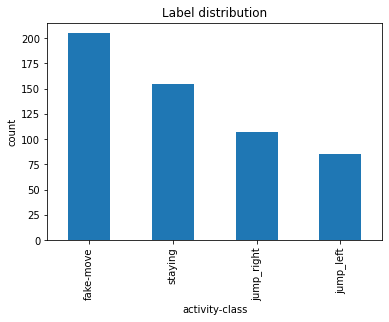

In [174]:
df[OUT_LABEL_COL].value_counts().plot.bar(title='Label distribution')
plt.ylabel('count')
plt.xlabel(OUT_LABEL_COL)
plt.show()

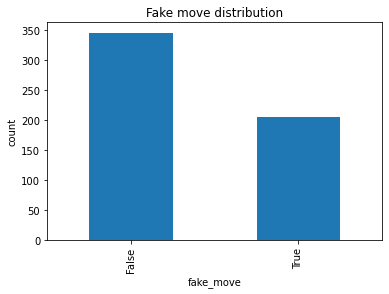

In [175]:
df['fake-move'].value_counts().plot.bar(title='Fake move distribution')
plt.ylabel('count')
plt.xlabel('fake_move')
plt.show()

In [176]:
MIN_NEG_CORR = -0.3
MIN_POS_CORR = 0.3

In [177]:
scaled_df = df.copy()

def drop_array_features(dataframe):
    # remove original array features
    for curFeature in arrayFeatures:
        dataframe.drop(curFeature, inplace=True, axis=1)

    # remove extracted array features
    dataframe.drop('acc-svmag', inplace=True, axis=1)
    dataframe.drop('gyr-svmag', inplace=True, axis=1)
    dataframe.drop('mag-svmag', inplace=True, axis=1)
    dataframe.drop('acc-x-fft', inplace=True, axis=1)
    dataframe.drop('acc-y-fft', inplace=True, axis=1)
    dataframe.drop('acc-z-fft', inplace=True, axis=1)
    dataframe.drop('gyr-x-fft', inplace=True, axis=1)
    dataframe.drop('gyr-y-fft', inplace=True, axis=1)
    dataframe.drop('gyr-z-fft', inplace=True, axis=1)
    dataframe.drop('mag-x-fft', inplace=True, axis=1)
    dataframe.drop('mag-y-fft', inplace=True, axis=1)
    dataframe.drop('mag-z-fft', inplace=True, axis=1)
    
drop_array_features(scaled_df)

In [178]:
# apply feature scaling
scaled_df.drop(SRC_LABEL_COL, inplace=True, axis=1)
scaled_df.drop(OUT_LABEL_COL, inplace=True, axis=1)

col_names = scaled_df.columns
scaled_df = pd.DataFrame(MinMaxScaler().fit_transform(scaled_df))
scaled_df.columns = col_names

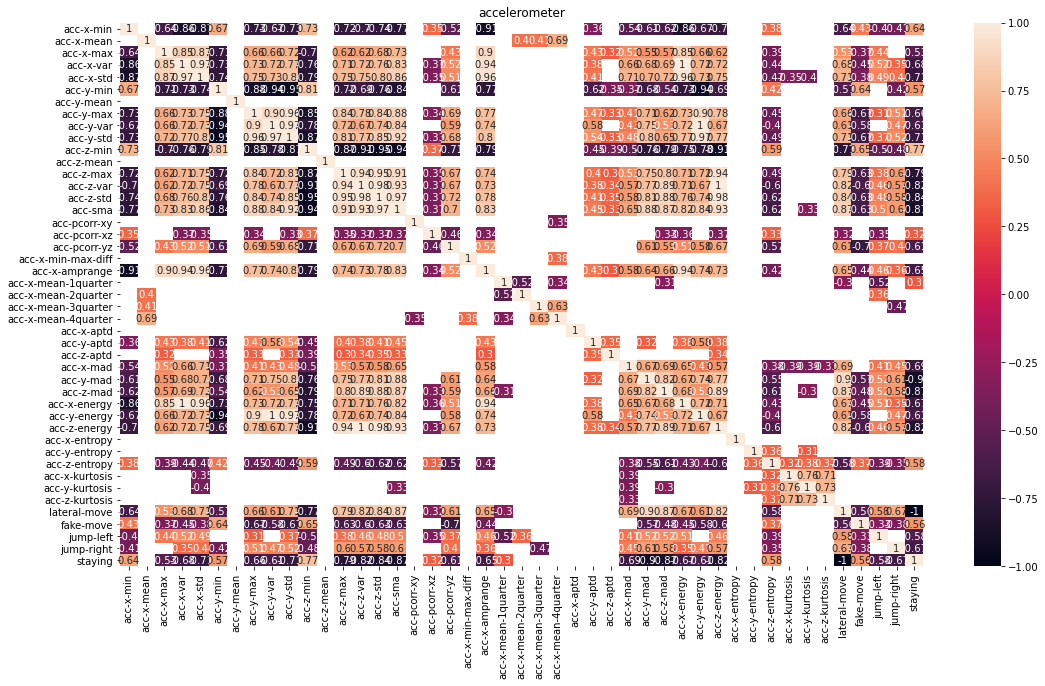

In [179]:
dfCorr = scaled_df[[
    'acc-x-min',
    'acc-x-mean',
    'acc-x-max',
    'acc-x-var',
    'acc-x-std',
    'acc-y-min',
    'acc-y-mean',
    'acc-y-max',
    'acc-y-var',
    'acc-y-std',
    'acc-z-min',
    'acc-z-mean',
    'acc-z-max',
    'acc-z-var',
    'acc-z-std',
    'acc-sma',
    'acc-pcorr-xy',
    'acc-pcorr-xz',
    'acc-pcorr-yz',
    'acc-x-min-max-diff',
    'acc-x-amprange',
    'acc-x-mean-1quarter',
    'acc-x-mean-2quarter',
    'acc-x-mean-3quarter',
    'acc-x-mean-4quarter',
    'acc-x-aptd',
    'acc-y-aptd',
    'acc-z-aptd',
    'acc-x-mad',
    'acc-y-mad',
    'acc-z-mad',
    'acc-x-energy',
    'acc-y-energy',
    'acc-z-energy',
    'acc-x-entropy',
    'acc-y-entropy',
    'acc-z-entropy',
    'acc-x-kurtosis',
    'acc-y-kurtosis',
    'acc-z-kurtosis',
    'lateral-move',
    'fake-move',
    'jump-left',
    'jump-right',
    'staying',
    #LABEL_COL
]].corr()

dfCorr = dfCorr[((dfCorr > MIN_POS_CORR) | (dfCorr < MIN_NEG_CORR))]

plt.figure(figsize=(18,10))
plt.title('accelerometer')
sn.heatmap(dfCorr, annot=True)
plt.show()

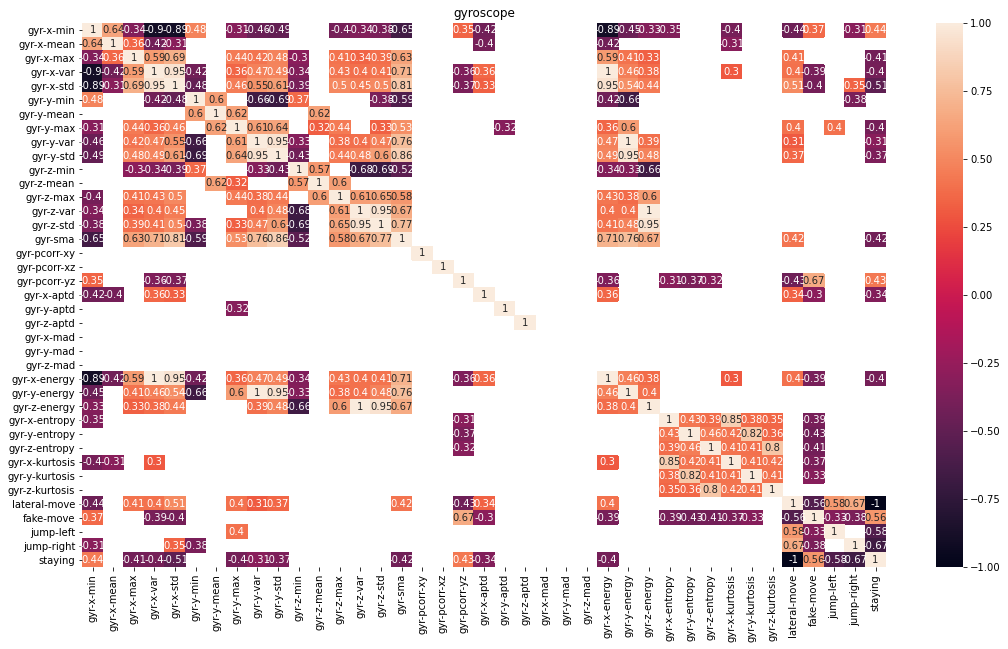

In [180]:
dfCorr = scaled_df[[
    'gyr-x-min',
    'gyr-x-mean',
    'gyr-x-max',
    'gyr-x-var',
    'gyr-x-std',
    'gyr-y-min',
    'gyr-y-mean',
    'gyr-y-max',
    'gyr-y-var',
    'gyr-y-std',
    'gyr-z-min',
    'gyr-z-mean',
    'gyr-z-max',
    'gyr-z-var',
    'gyr-z-std',
    'gyr-sma',
    'gyr-pcorr-xy',
    'gyr-pcorr-xz',
    'gyr-pcorr-yz',
    'gyr-x-aptd',
    'gyr-y-aptd',
    'gyr-z-aptd',
    'gyr-x-mad',
    'gyr-y-mad',
    'gyr-z-mad',
    'gyr-x-energy',
    'gyr-y-energy',
    'gyr-z-energy',
    'gyr-x-entropy',
    'gyr-y-entropy',
    'gyr-z-entropy',
    'gyr-x-kurtosis',
    'gyr-y-kurtosis',
    'gyr-z-kurtosis',
    'lateral-move',
    'fake-move',
    'jump-left',
    'jump-right',
    'staying',
    #LABEL_COL
]].corr()

dfCorr = dfCorr[((dfCorr > MIN_POS_CORR) | (dfCorr < MIN_NEG_CORR))]

plt.figure(figsize=(18,10))
plt.title('gyroscope')
sn.heatmap(dfCorr, annot=True)
plt.show()

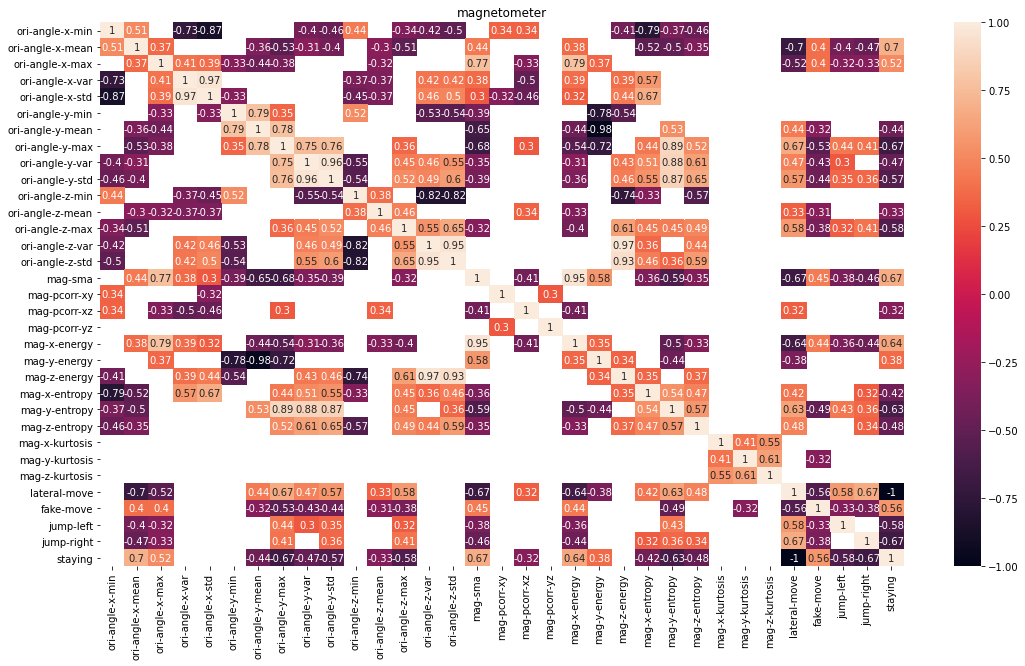

In [181]:
dfCorr = scaled_df[[
    'ori-angle-x-min',
    'ori-angle-x-mean',
    'ori-angle-x-max',
    'ori-angle-x-var',
    'ori-angle-x-std',
    'ori-angle-y-min',
    'ori-angle-y-mean',
    'ori-angle-y-max',
    'ori-angle-y-var',
    'ori-angle-y-std',
    'ori-angle-z-min',
    'ori-angle-z-mean',
    'ori-angle-z-max',
    'ori-angle-z-var',
    'ori-angle-z-std',
    'mag-sma',
    'mag-pcorr-xy',
    'mag-pcorr-xz',
    'mag-pcorr-yz',
    'mag-x-energy',
    'mag-y-energy',
    'mag-z-energy',
    'mag-x-entropy',
    'mag-y-entropy',
    'mag-z-entropy',
    'mag-x-kurtosis',
    'mag-y-kurtosis',
    'mag-z-kurtosis',
    'lateral-move',
    'fake-move',
    'jump-left',
    'jump-right',
    'staying',
    #LABEL_COL
]].corr()

dfCorr = dfCorr[((dfCorr > MIN_POS_CORR) | (dfCorr < MIN_NEG_CORR))]

plt.figure(figsize=(18,10))
plt.title('magnetometer')
sn.heatmap(dfCorr, annot=True)
plt.show()

In [182]:
#move label column to the end
activityClassColumn = df.pop(OUT_LABEL_COL)
df[OUT_LABEL_COL] = activityClassColumn;

In [183]:
def drop_activity_label_features(dataFrame):
    dataFrame.drop(SRC_LABEL_COL, inplace=True, axis=1)
    dataFrame.drop(LABEL_COL, inplace=True, axis=1)
    dataFrame.drop('lateral-move', inplace=True, axis=1)
    dataFrame.drop('fake-move', inplace=True, axis=1)
    dataFrame.drop('jump-left', inplace=True, axis=1)
    dataFrame.drop('jump-right', inplace=True, axis=1)
    dataFrame.drop('staying', inplace=True, axis=1)

In [184]:
def drop_irrelevante_features(dataFrame):
    #gyroscope
    dataFrame.drop('gyr-x-aptd', inplace=True, axis=1)
    dataFrame.drop('gyr-y-aptd', inplace=True, axis=1)
    dataFrame.drop('gyr-z-aptd', inplace=True, axis=1)
    dataFrame.drop('gyr-x-mad', inplace=True, axis=1)
    dataFrame.drop('gyr-y-mad', inplace=True, axis=1)
    dataFrame.drop('gyr-z-mad', inplace=True, axis=1)
    
    #magnetometer
    dataFrame.drop('ori-angle-x-min', inplace=True, axis=1)
    dataFrame.drop('ori-angle-x-mean', inplace=True, axis=1)
    dataFrame.drop('ori-angle-x-max', inplace=True, axis=1)
    dataFrame.drop('ori-angle-x-var', inplace=True, axis=1)
    dataFrame.drop('ori-angle-x-std', inplace=True, axis=1)
    dataFrame.drop('mag-pcorr-xy', inplace=True, axis=1)
    dataFrame.drop('mag-pcorr-xz', inplace=True, axis=1)
    dataFrame.drop('mag-pcorr-zy', inplace=True, axis=1)

In [185]:
# export dataset
scaled_df = df.copy()

drop_array_features(scaled_df)
drop_activity_label_features(scaled_df)
#drop_irrelevante_features(scaled_df)

scaled_df.to_csv(src_folder_path + '/dataset.csv', index=False, header=True, sep=",", decimal='.')

In [186]:
def get_activity_class_laterals(activityCode):
    if activityCode == JUMP_LEFT or activityCode == JUMP_RIGHT:
        return 'lateral-move'
    if activityCode == FAKE_JUMP_LEFT or activityCode== FAKE_JUMP_RIGHT:
        return 'fake-move'
    else:
        return 'staying'

# export dataset
scaled_df = df.copy()

scaled_df[OUT_LABEL_COL] = scaled_df[LABEL_COL].apply(get_activity_class_laterals)

drop_array_features(scaled_df)
drop_activity_label_features(scaled_df)
#drop_irrelevante_features(scaled_df)

scaled_df.to_csv(src_folder_path + '/dataset-laterals-step1.csv', index=False, header=True, sep=",", decimal='.')

In [187]:
#export side movement dataset
scaled_df = df.copy()
scaled_df = scaled_df[scaled_df['lateral-move'] == True]

drop_array_features(scaled_df)
drop_activity_label_features(scaled_df)
#drop_irrelevante_features(scaled_df)

scaled_df.to_csv(src_folder_path + '/dataset-laterals-step2.csv', index=False, header=True, sep=",", decimal='.')

del scaled_df

Index(['acc-x-min', 'acc-x-mean', 'acc-x-max', 'acc-x-var', 'acc-x-std',
       'acc-y-min', 'acc-y-mean', 'acc-y-max', 'acc-y-var', 'acc-y-std',
       ...
       'mag-x-energy', 'mag-y-energy', 'mag-z-energy', 'mag-x-entropy',
       'mag-y-entropy', 'mag-z-entropy', 'mag-x-kurtosis', 'mag-y-kurtosis',
       'mag-z-kurtosis', 'activity-class'],
      dtype='object', length=103)
